<a href="https://colab.research.google.com/github/ghoshdebapratim1/AmosLabCode/blob/main/Clustering_of_Survey_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fancyimpute
! pip install kmodes
! pip install gower
! pip install bevel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 6.8 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=2ba9d72eb9180474dbe976eaf8677327b7d2186d52ddbaec5606fd9e2d59d59e
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11355 sha256=ee39e4b19df0d3fed1d520838394c7630abde7341d75f9b223339130e56d69cc
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import pandas as pd 
import numpy as np
from google.colab import drive 

drive.mount('/content/drive')

import pandas as pd

from fancyimpute import IterativeImputer as MICE

from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from kmodes.kprototypes import KPrototypes

from gower import gower_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score

import seaborn as sns

from sklearn.cluster import KMeans

Mounted at /content/drive


## Cleaning the data

In [ ]:
path_piiData='/content/drive/MyDrive/Amos Lab/Amos Lab Data/UIC/COMPASS Survey_September 28, 2022_08.11.csv'

data=pd.read_csv(path_piiData)

data=data.iloc[8:,:]

# Renaming the Major and UIN Columns 

data = data.rename(columns={'Q2': 'uin', 'Q3': 'major'})
data['uin']=data['uin'].astype(str)

compass_data=pd.read_csv('/content/drive/MyDrive/Amos Lab/Amos Lab Data/UIC/UIC_Compass.txt',sep="\t",header=[1])
compass_data.rename(columns={'UIN': 'uin'}, inplace=True)
compass_data['uin']=compass_data['uin'].apply(str)

data_merged = pd.merge(data, compass_data, how="left", on=["uin"])

data_responses=data_merged.drop([ 'StartDate', 'EndDate', 'Status', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'major', 'uin', 'IPAddress','Q9', 'Last Name',
       'Legal First Name', 'Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name'],axis=1)

trans = MICE(verbose=False)
trans.fit(data_responses)
data_res_imputed = trans.transform(data_responses)

data_res_imputed=pd.DataFrame(data_res_imputed)

data_res_imputed.columns=['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9',
       'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4',
       'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q8_1', 'Q8_2',
       'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10',
       'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18',
       'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26',
       'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33']

data_res_imputed=data_res_imputed.round(0)


data_factors=data_merged[['Primary Curr Major Name','Race Description','International Birth Nation Name','Address State Name','uin']]
data_factors=data_factors.replace(r'^\s*$', np.nan, regex=True)
data_factors.fillna('Not Reported',inplace=True)

def inStateStatus(df):    
    if ((df['International Birth Nation Name']=='Not Reported' )& (df['Address State Name']=='Illinois' )):
        return 'Domestic In State'
    elif ((df['International Birth Nation Name']=='Not Reported' )& (df['Address State Name']!='Illinois' )):
        return 'Domestic Out of State'
    else :
        return 'International'



data_factors['student_status']= data_factors.apply(inStateStatus, axis = 1)

data_for_clustering=pd.concat([data_factors,pd.DataFrame(data_res_imputed)],axis=1)

uin=data_for_clustering.uin 

data_for_clustering.drop('uin',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


## t-SNE Plot using Gower Distance

In [ ]:
X=data_for_clustering.copy()

In [ ]:
dist_mat=gower_matrix(X)
dist_mat

array([[0.        , 0.26984128, 0.38333333, ..., 0.21746032, 0.2452381 ,
        0.16190477],
       [0.26984128, 0.        , 0.2563492 , ..., 0.21746032, 0.29285714,
        0.24126984],
       [0.38333333, 0.2563492 , 0.        , ..., 0.18968254, 0.24126984,
        0.22936508],
       ...,
       [0.21746032, 0.21746032, 0.18968254, ..., 0.        , 0.09126984,
        0.07936508],
       [0.2452381 , 0.29285714, 0.24126984, ..., 0.09126984, 0.        ,
        0.1388889 ],
       [0.16190477, 0.24126984, 0.22936508, ..., 0.07936508, 0.1388889 ,
        0.        ]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


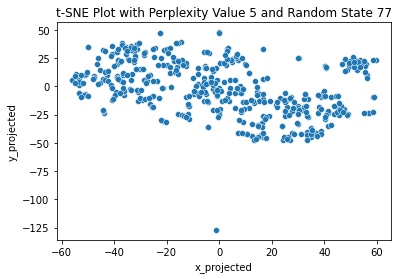

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


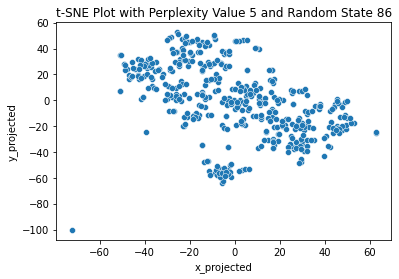

--------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


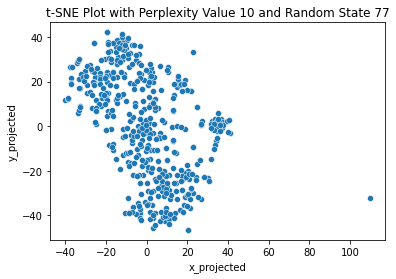

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


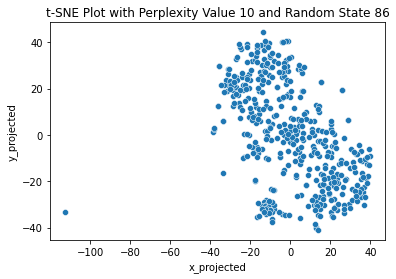

--------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


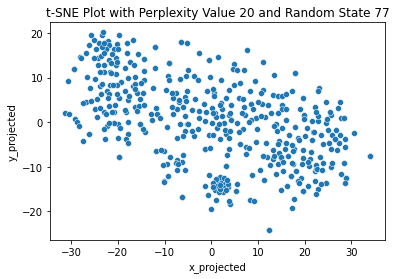

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


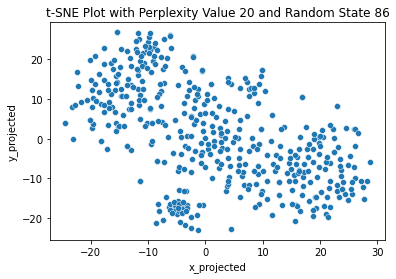

--------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


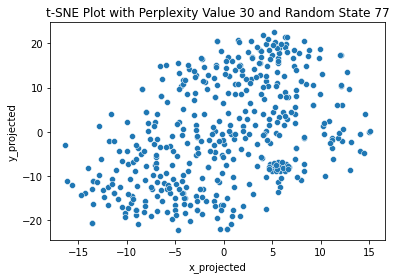

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


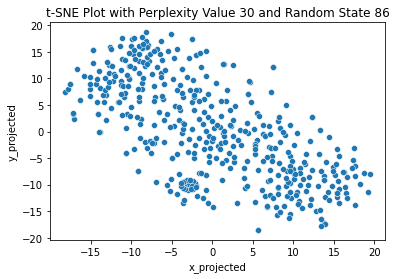

--------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


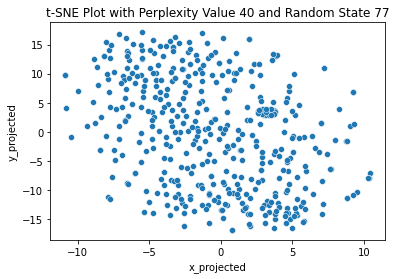

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


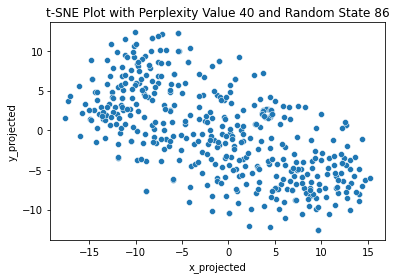

--------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


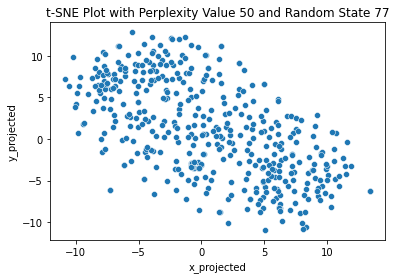

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


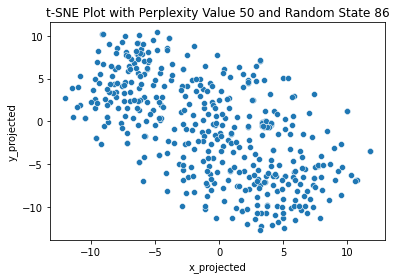

--------------------------------------------


In [ ]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [77,86]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([data_for_clustering, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


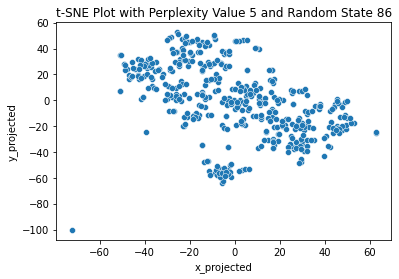

--------------------------------------------


In [ ]:
for perp in [5]:
    for rs in [86]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([data_for_clustering, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

## Using k-prototypes for elbow plot

In [ ]:
X.columns

Index(['Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6',
       'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1',
       'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4',
       'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8',
       'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16',
       'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24',
       'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32',
       'Q8_33'],
      dtype='object')

In [ ]:
cost = []
for num_clusters in list(range(1,10)):
    print(num_clusters)
    kp = KPrototypes(n_clusters=num_clusters, random_state=100)
    kp.fit_predict(X, categorical=[0,1,2,3,4])
    cost.append(kp.cost_)

1
2
3
4
5
6
7
8
9


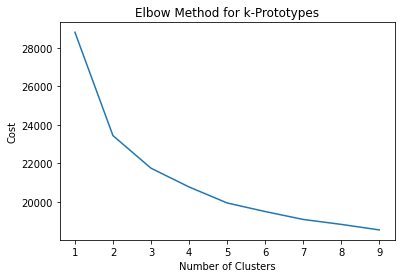

In [ ]:
plt.plot(list(range(1,10)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes')
plt.show()

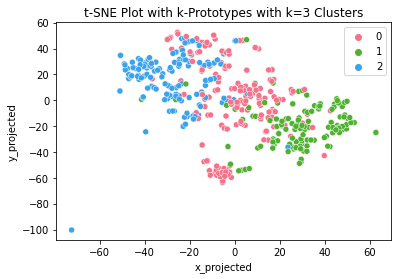

In [ ]:
k=3
kp = KPrototypes(n_clusters=k, random_state=1000)
fit_clusters = kp.fit_predict(X,categorical=[0,1,2,3,4])
df_combo['predicted_cluster']=fit_clusters
df_combo['predicted_cluster']=df_combo['predicted_cluster'].astype(int)
sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
plt.title('t-SNE Plot with k-Prototypes with k=%s Clusters' %(k))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## HAC with Single Linkage

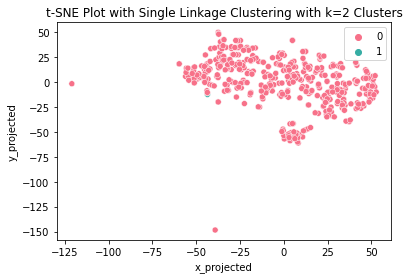

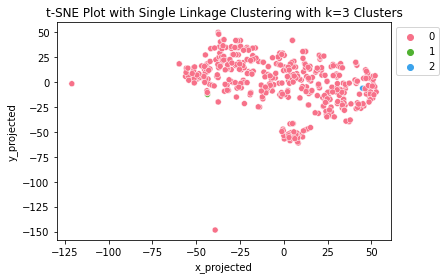

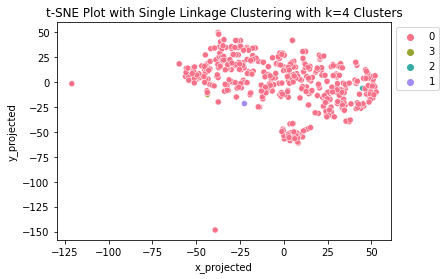

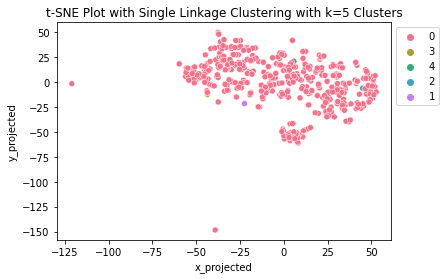

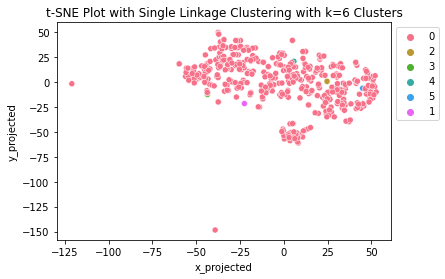

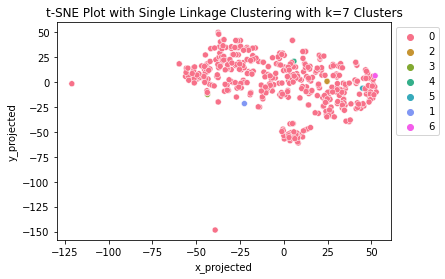

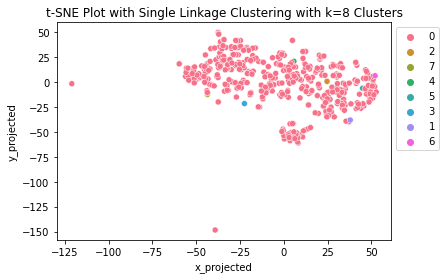

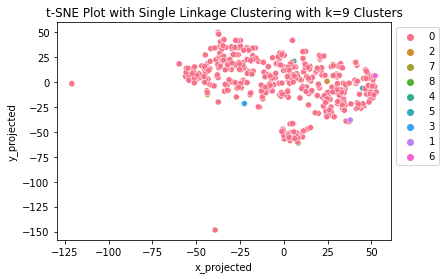

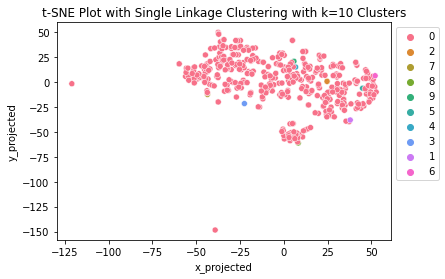

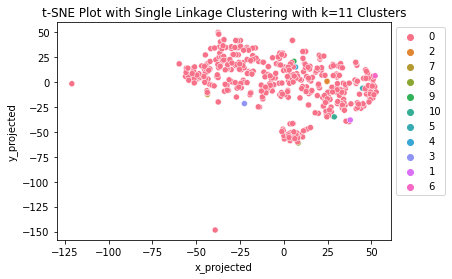

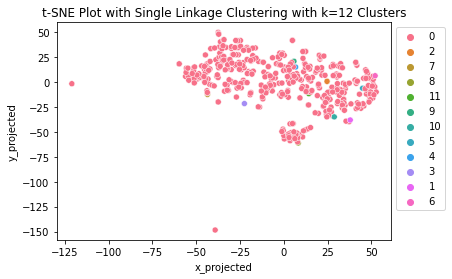

In [ ]:
link="single"
dm=squareform(dist_mat, force = 'tovector')
Z = linkage(dm, method=link)
for k in range(2,13):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage=link)
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    df_combo['predicted_cluster']=df_combo['predicted_cluster'].astype(str)
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Single Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

## HAC with Complete Linkage

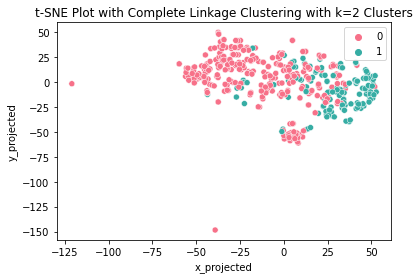

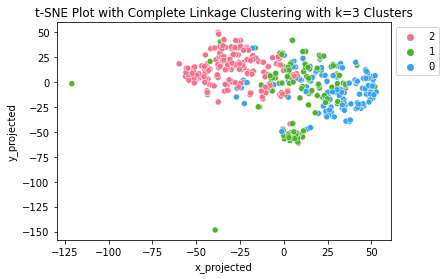

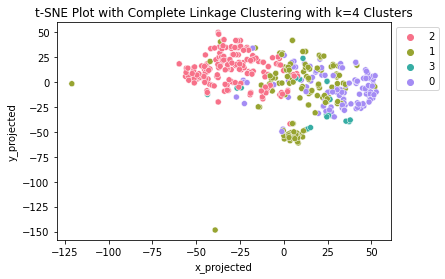

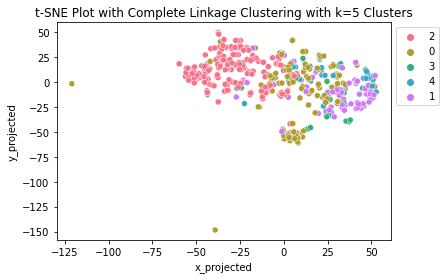

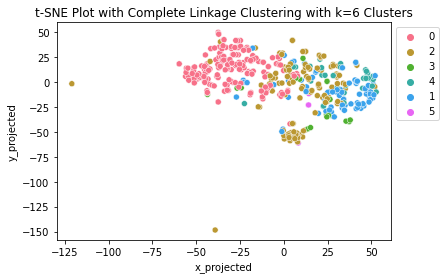

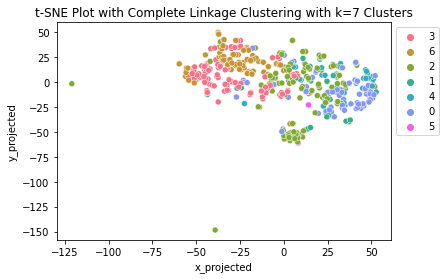

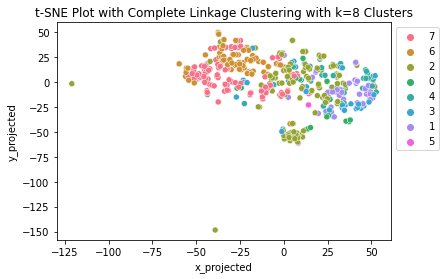

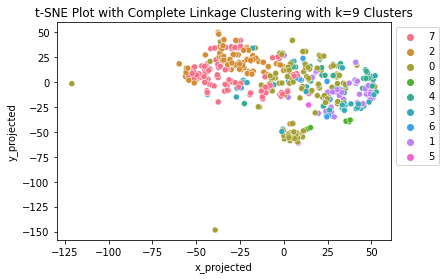

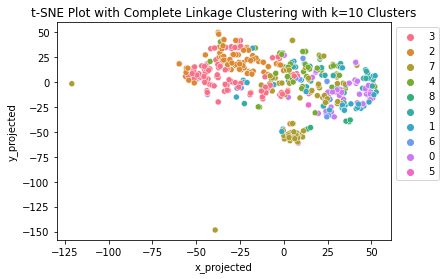

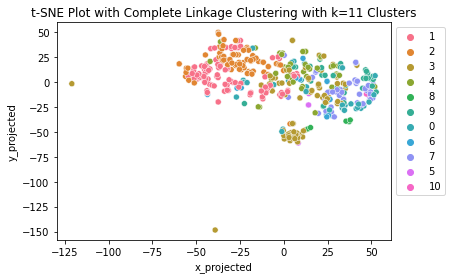

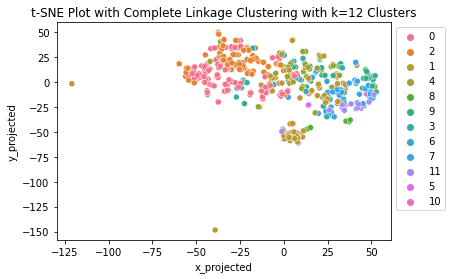

In [ ]:
link="complete"
dm=squareform(dist_mat, force = 'tovector')
Z = linkage(dm, method=link)
for k in range(2,13):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage=link)
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    df_combo['predicted_cluster']=df_combo['predicted_cluster'].astype(str)
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Complete Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

## HAC with Average Linkage


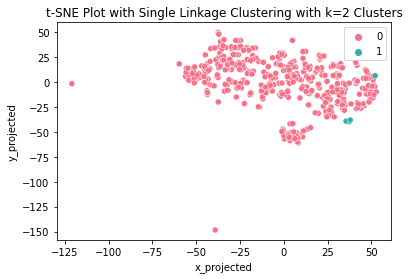

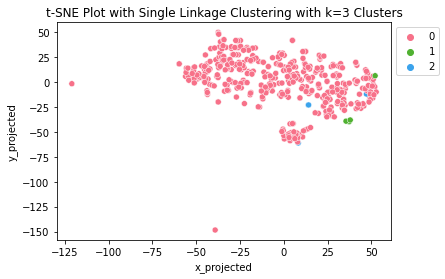

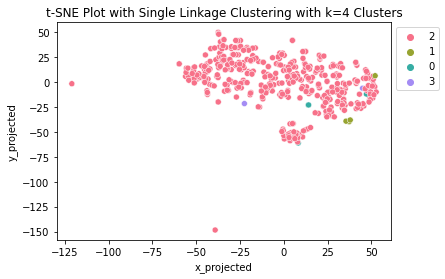

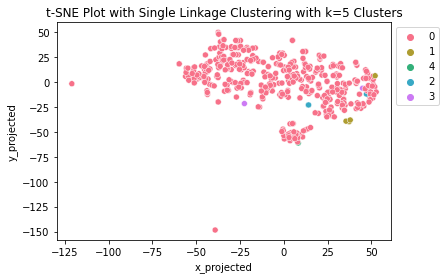

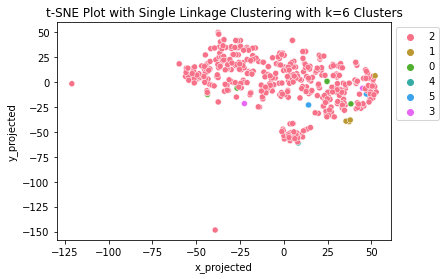

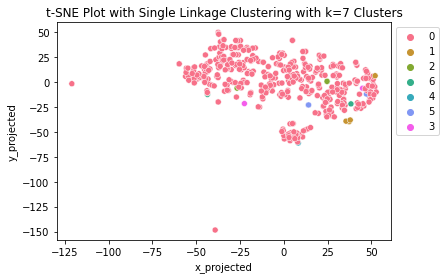

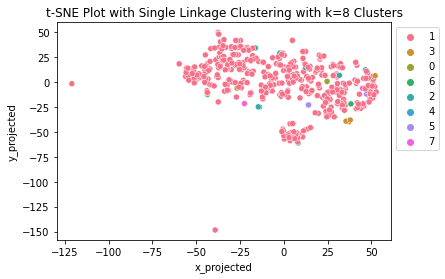

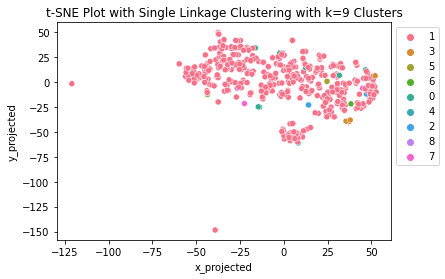

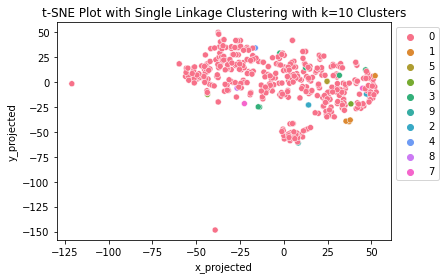

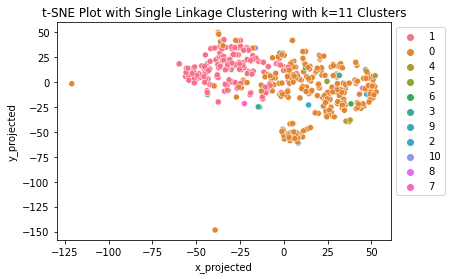

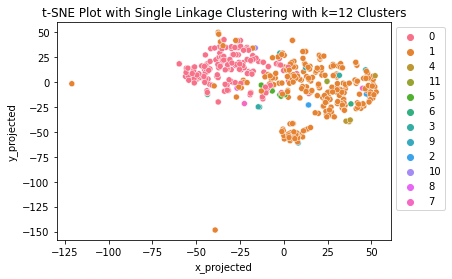

In [ ]:
link="average"
dm=squareform(dist_mat, force = 'tovector')
Z = linkage(dm, method=link)
for k in range(2,13):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage=link)
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    df_combo['predicted_cluster']=df_combo['predicted_cluster'].astype(str)
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Single Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


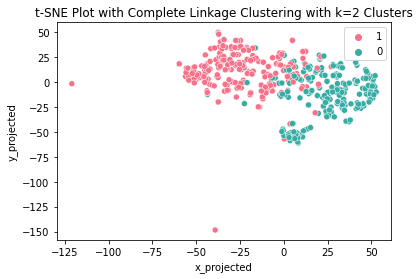

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


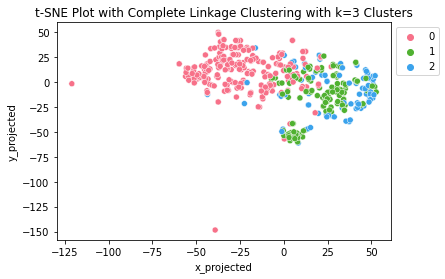

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


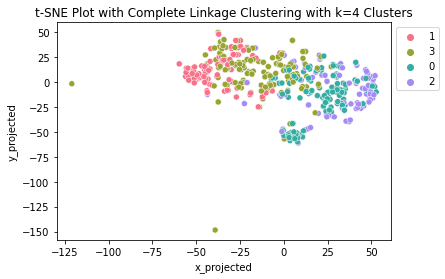

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


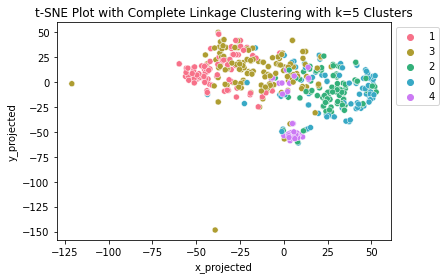

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


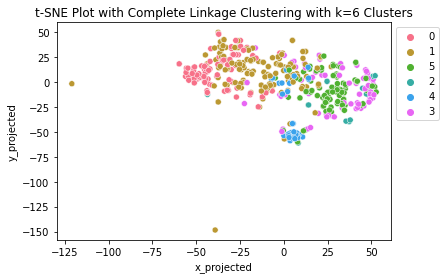

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


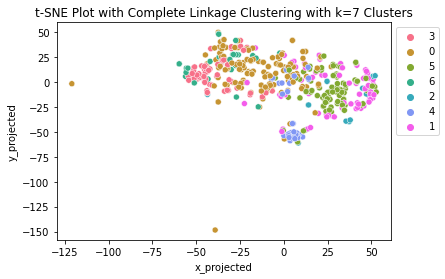

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


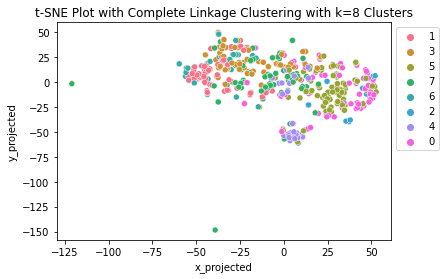

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


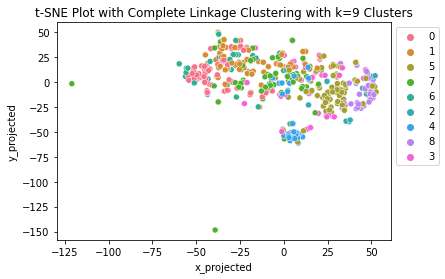

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


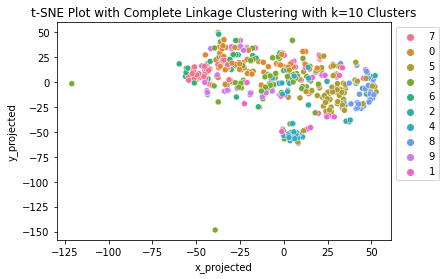

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


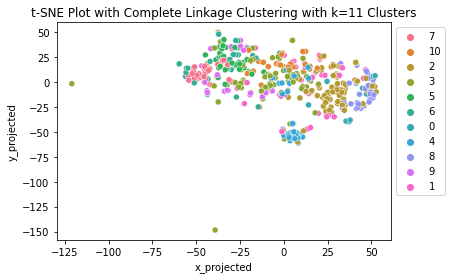

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


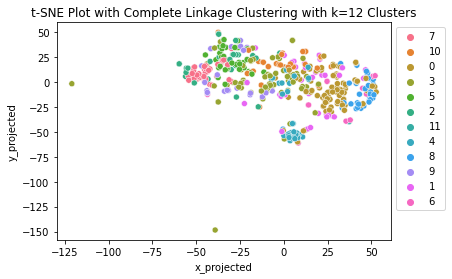

In [ ]:
link="ward"
dm=squareform(dist_mat, force = 'tovector')
Z = linkage(dm, method=link)
for k in range(2,13):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, linkage=link)
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    df_combo['predicted_cluster']=df_combo['predicted_cluster'].astype(str)
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Complete Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

k= 1
k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10
k= 11


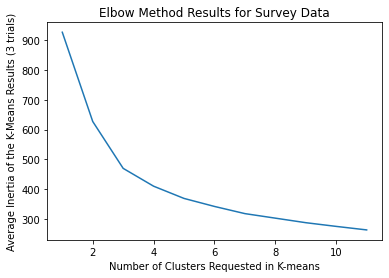

In [ ]:


cluster_num_list=range(1,12)
avg_inertia_list=[]
for k in cluster_num_list:
    print('k= '+str(k))
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(dist_mat)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Survey Data')
plt.show()

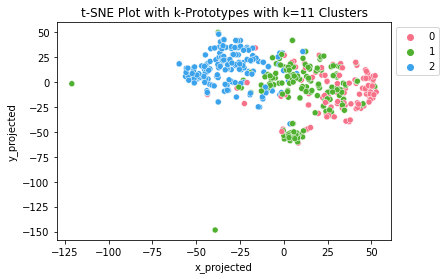

In [ ]:
kmeans=KMeans(n_clusters=3).fit(dist_mat)
df_combo['predicted_cluster_kmeans']=kmeans.labels_
sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster_kmeans', palette=sns.color_palette("husl", 3), data=df_combo)
plt.title('t-SNE Plot with k-Means with k=%s Clusters' %(k))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Average Silhouette Scores of 3 Clusterings, Each with k=2 Clusters
[0.27643588, 0.27643588, 0.27643588]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Average Silhouette Scores of 3 Clusterings, Each with k=3 Clusters
[0.250218, 0.250218, 0.250218]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance ma

Average Silhouette Scores of 3 Clusterings, Each with k=4 Clusters
[0.1850241, 0.1850241, 0.1850241]
Average Silhouette Scores of 3 Clusterings, Each with k=5 Clusters
[0.18232623, 0.18232623, 0.18232623]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance ma

Average Silhouette Scores of 3 Clusterings, Each with k=6 Clusters
[0.18307778, 0.18307778, 0.18307778]
Average Silhouette Scores of 3 Clusterings, Each with k=7 Clusters
[0.17810597, 0.17810597, 0.17810597]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance ma

Average Silhouette Scores of 3 Clusterings, Each with k=8 Clusters
[0.16665973, 0.16665973, 0.16665973]
Average Silhouette Scores of 3 Clusterings, Each with k=9 Clusters
[0.1656666, 0.1656666, 0.1656666]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance ma

Average Silhouette Scores of 3 Clusterings, Each with k=10 Clusters
[0.16820997, 0.16820997, 0.16820997]
Average Silhouette Scores of 3 Clusterings, Each with k=11 Clusters
[0.15858957, 0.15858957, 0.15858957]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance ma

Average Silhouette Scores of 3 Clusterings, Each with k=12 Clusters
[0.16151506, 0.16151506, 0.16151506]
Average Silhouette Scores of 3 Clusterings, Each with k=13 Clusters
[0.14356428, 0.14356428, 0.14356428]


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Average Silhouette Scores of 3 Clusterings, Each with k=14 Clusters
[0.14938788, 0.14938788, 0.14938788]


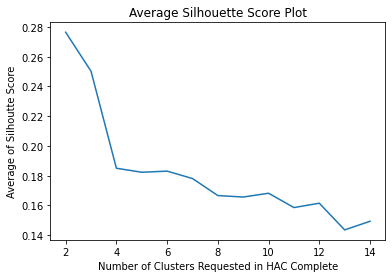

In [ ]:
#Evaluating for k=2,3,...,14 clusters
cluster_num_list=range(2,15)

#Will use 3 trials (ie. generate 3 clusterings) for each k
trial_num=3

#Generating a List of Average Average Silhouette Scores 
avg_avg_sil_score_list=[]
for k in cluster_num_list:
    avg_sil_score_list=[]
    for i in range(0,trial_num):
        #Clusters the dataset
        hac = AgglomerativeClustering(n_clusters=k, linkage=link)
        df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
        
        #Extract the cluster labels of the clustering
        cluster_labels = df_combo['predicted_cluster']
        
        #Finds the average silhoutte score of ALL objects in the given clustering
        avg_sil_score=silhouette_score(dist_mat, cluster_labels)
        
        #Appends this 
        avg_sil_score_list.append(avg_sil_score)
    print('Average Silhouette Scores of %s Clusterings, Each with k=%s Clusters'%(trial_num,k))
    print(avg_sil_score_list)
    
    #Takes the average of the three average silhouette scores (from each of the three clustering with k clusters produced)
    avg_avg_sil_score_list.append(np.average(avg_sil_score_list))

#Plot it    
plt.plot(cluster_num_list,avg_avg_sil_score_list)
plt.xlabel('Number of Clusters Requested in HAC Complete')
plt.ylabel('Average of Silhoutte Score')
plt.title('Average Silhouette Score Plot')
plt.show()

## Assessing Best Clustering for k=2

In [ ]:
k=3
hac = AgglomerativeClustering(n_clusters=k, linkage='complete')
df_combo['predicted_cluster_hac'] = hac.fit_predict(dist_mat)
kp = KPrototypes(n_clusters=k, random_state=100)
fit_clusters = kp.fit_predict(X,categorical=[0,1,2,3,4])
df_combo['predicted_cluster_k_proto']=fit_clusters
df_combo['predicted_cluster_k_proto']=df_combo['predicted_cluster_k_proto'].astype(str)

kmeans=KMeans(n_clusters=k).fit(dist_mat)
df_combo['predicted_cluster_kmeans']=kmeans.labels_
df_combo['predicted_cluster_kmeans']=df_combo['predicted_cluster_kmeans'].astype(str)
print(silhouette_score(dist_mat, df_combo['predicted_cluster_hac']))
print(silhouette_score(dist_mat, df_combo['predicted_cluster_k_proto']))
print(silhouette_score(dist_mat, df_combo['predicted_cluster_kmeans']))

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


0.22786526
0.18025583
0.27489382


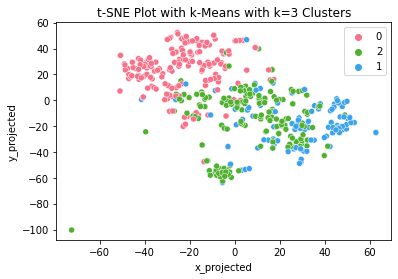

In [ ]:
sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster_kmeans', palette=sns.color_palette("husl", k), data=df_combo)
plt.title('t-SNE Plot with k-Means with k=%s Clusters' %(k))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
df_combo['predicted_cluster_kmeans'].value_counts()

0    170
2    166
1    101
Name: predicted_cluster_kmeans, dtype: int64

In [ ]:
df_combo.columns

Index(['Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6',
       'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1',
       'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4',
       'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8',
       'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16',
       'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24',
       'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32',
       'Q8_33', 'x_projected', 'y_projected', 'predicted_cluster_hac',
       'predicted_cluster_k_proto', 'predicted_cluster_kmeans'],
      dtype='object')

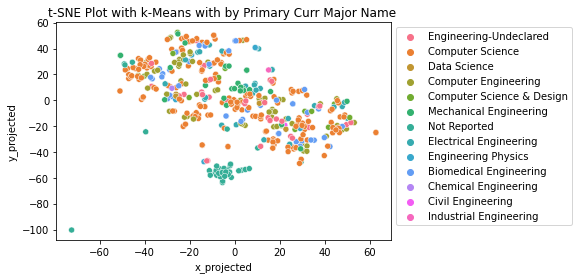

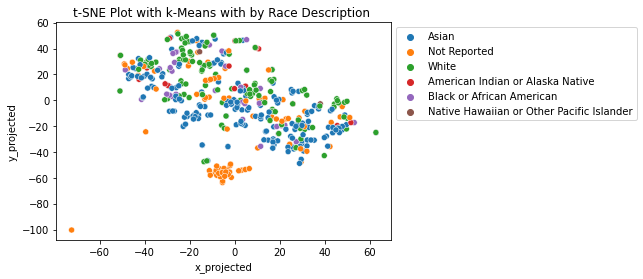

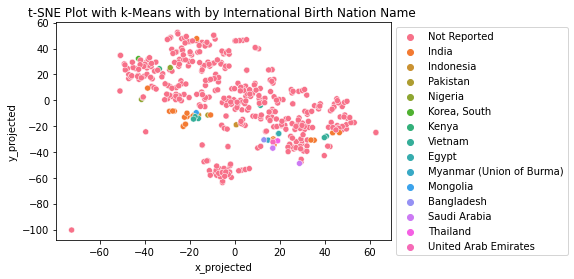

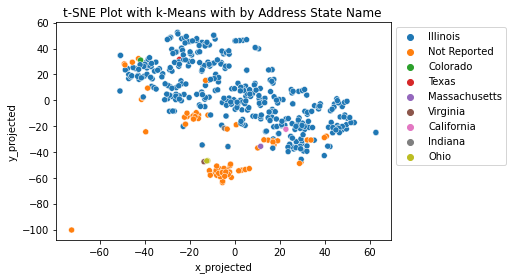

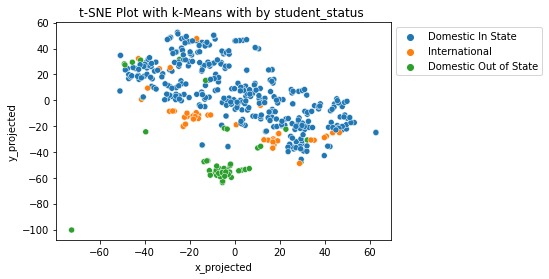

In [ ]:
for col in ['Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status']:


        sns.scatterplot(x='x_projected',y='y_projected', hue=data_for_clustering[col], data=df_combo)
        plt.title('t-SNE Plot with k-Means with by %s ' %(col))
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()

In [ ]:
data_for_clustering['Primary Curr Major Name'].value_counts()

Computer Science             184
Computer Engineering          60
Biomedical Engineering        41
Not Reported                  37
Engineering-Undeclared        35
Electrical Engineering        29
Mechanical Engineering        25
Computer Science & Design     12
Engineering Physics            6
Data Science                   5
Chemical Engineering           1
Civil Engineering              1
Industrial Engineering         1
Name: Primary Curr Major Name, dtype: int64

In [ ]:
data_for_clustering['International Birth Nation Name']=data_for_clustering['International Birth Nation Name'].replace(r'\s+', ' ', regex=True)

In [ ]:
data_for_clustering['International Birth Nation Name']=data_for_clustering['International Birth Nation Name'].str.replace(' ', 'Not Reported')
data_for_clustering['student_status'].value_counts()

Domestic In State        342
Domestic Out of State     50
International             45
Name: student_status, dtype: int64

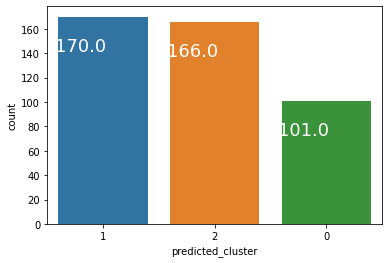

In [ ]:



counts = df_combo['predicted_cluster_kmeans'].value_counts().rename_axis('predicted_cluster').reset_index(name='count')

ax = sns.barplot(x='predicted_cluster', y='count', data=counts)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)

In [ ]:
round(df_combo['predicted_cluster_kmeans'].value_counts(normalize=True)*30,0)

1    12.0
2    11.0
0     7.0
Name: predicted_cluster_kmeans, dtype: float64

In [ ]:
df_combo.shape

(437, 68)

In [ ]:
df_for_sampling=pd.concat([uin,df_combo,data_merged['Q9']],axis=1)
df_for_sampling = df_for_sampling[df_for_sampling['uin']!='nan']
df_for_sampling=df_for_sampling[df_for_sampling['Q9']=='1']

In [ ]:
df_for_sampling['predicted_cluster_kmeans'].value_counts()

0    56
1    37
2    34
Name: predicted_cluster_kmeans, dtype: int64

In [ ]:
sample_0=df_for_sampling[df_for_sampling['predicted_cluster_kmeans']=='0'].sample(27,random_state=3001, replace=False)
sample_1=df_for_sampling[df_for_sampling['predicted_cluster_kmeans']=='1'].sample(27,random_state=300, replace=False)
sample_2=df_for_sampling[df_for_sampling['predicted_cluster_kmeans']=='2'].sample(27,random_state=300, replace=False)
sample=pd.concat([sample_0,sample_1,sample_2],axis=0)
sample['Primary Curr Major Name'].value_counts()

Computer Science          36
Biomedical Engineering    10
Electrical Engineering     8
Engineering-Undeclared     7
Mechanical Engineering     6
Computer Engineering       6
Not Reported               3
Engineering Physics        2
Data Science               2
Industrial Engineering     1
Name: Primary Curr Major Name, dtype: int64

In [ ]:
sample.uin.value_counts()

674334254    2
654838636    2
678425135    1
664058633    1
657986463    1
            ..
662543824    1
677613608    1
669905479    1
672139493    1
661429662    1
Name: uin, Length: 79, dtype: int64

In [ ]:
sample2['predicted_cluster_kmeans'].value_counts()

2    9
1    8
0    7
Name: predicted_cluster_kmeans, dtype: int64

In [ ]:

sample2 = pd.merge(sample, data_merged, how="left", on=["uin"])
sample2.drop_duplicates(inplace=True)
sample2[['uin','Primary Curr Major Name_x', 'Legal First Name','Last Name','predicted_cluster_kmeans','Q9_x']].to_csv('/content/drive/MyDrive/Amos Lab/Amos Lab Data/Sample and Analysis/sample_uic_expanded.csv')

In [ ]:
sample2.drop_duplicates(inplace=True)

In [ ]:
sample2[['uin','Primary Curr Major Name_x', 'Legal First Name','Last Name','predicted_cluster_kmeans']]

,uin,Primary Curr Major Name_x,Legal First Name,Last Name,predicted_cluster_kmeans
0,678425135,Electrical Engineering,Leonardo,Guzman,0
1,656043234,Computer Science,Khushbakht,Mohsin,0
2,665000094,Biomedical Engineering,Alexandria,Sterenberg,0
3,663763842,Computer Science,Yuseok,Lee,0
4,664578422,Electrical Engineering,La'darius,Yancey-Lynn,0
...,...,...,...,...,...
81,654837955,Biomedical Engineering,Siri,Harish,2
82,671802681,Computer Engineering,Jeremy,Angumei,2
83,671790614,Computer Science,Damon,Chen,2
84,650321892,Data Science,Bader,Rezek,2


## Post Cluster Analysis

In [ ]:
df_for_sampling.shape

(413, 70)

In [ ]:
df_for_sampling.columns

Index(['uin', 'Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6',
       'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1',
       'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4',
       'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8',
       'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16',
       'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24',
       'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32',
       'Q8_33', 'x_projected', 'y_projected', 'predicted_cluster_hac',
       'predicted_cluster_k_proto', 'predicted_cluster_kmeans', 'Q9'],
      dtype='object')

In [ ]:
def stacked_bar(df_inp,y_col,col_list,fig_height=10,fig_width=5,is_perc=False):
  import matplotlib.pyplot as plt 

  for col in col_list:
  
        df_test=df_inp.groupby(y_col)[col].value_counts(is_perc).unstack(col).fillna(0)
        df_test2=df_inp.groupby(y_col)[col].value_counts(normalize=False).unstack(col).fillna(0)
        s = df_test2.sum(axis=1).sort_values(ascending=True)
        df_test=df_test.loc[s.index]
        count=df_test.plot.barh(stacked=True,figsize=(fig_width, fig_height))
        count.set_title(col, fontdict={'fontsize':12}, pad=12)

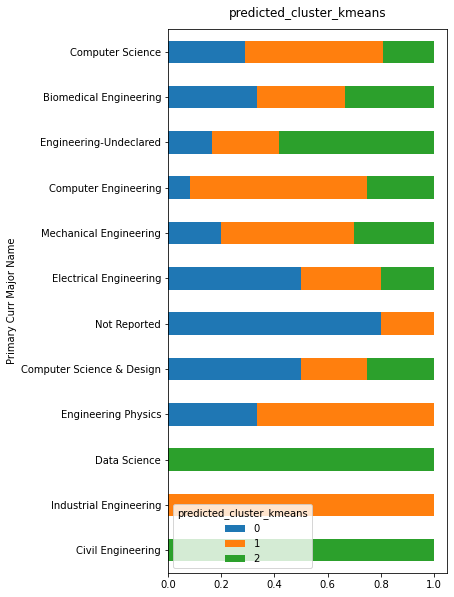

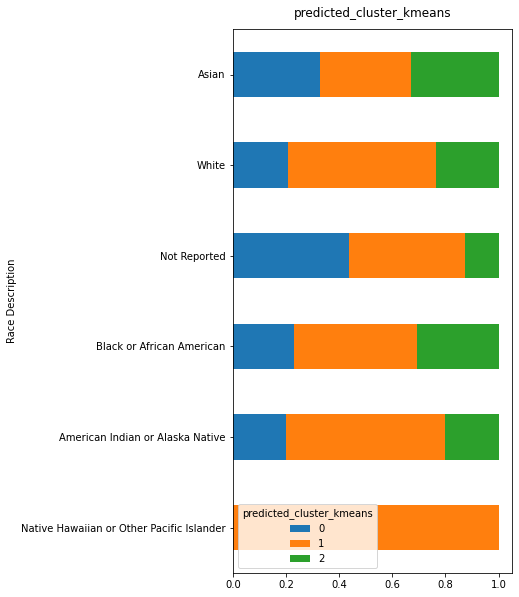

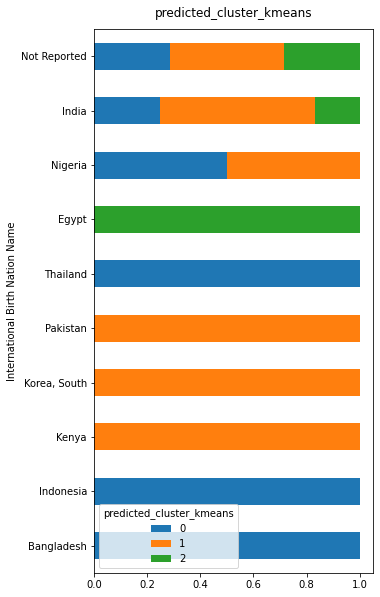

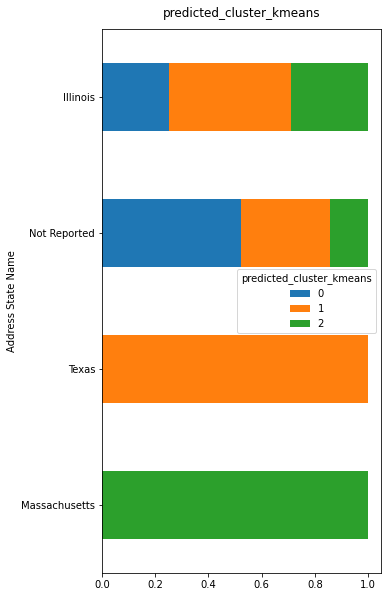

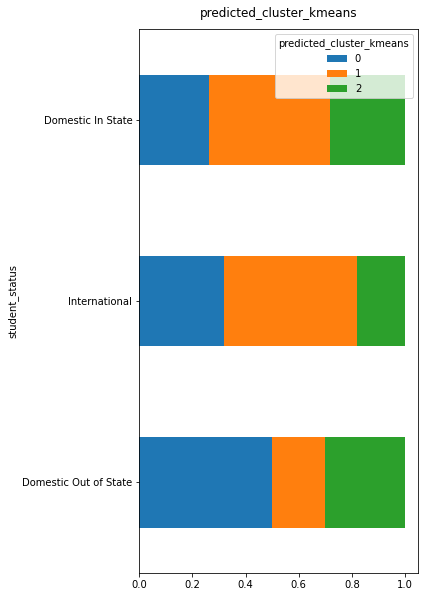

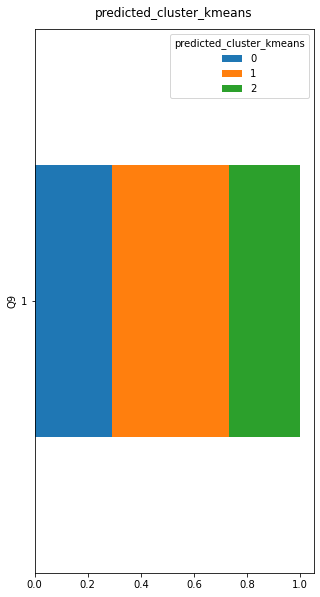

In [ ]:
col_list=['Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status','Q9']

for col in col_list:

      stacked_bar(df_for_sampling,col,['predicted_cluster_kmeans'],is_perc=True)

In [ ]:
df_for_sampling.columns

Index(['uin', 'Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6',
       'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1',
       'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4',
       'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8',
       'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16',
       'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24',
       'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32',
       'Q8_33', 'x_projected', 'y_projected', 'predicted_cluster_hac',
       'predicted_cluster_k_proto', 'predicted_cluster_kmeans', 'Q9',
       'mean_car_dec_making', 'mean_car_exp_plans', 'mean_car_env_plans',
       'mean_car_self_plans', 'mean_car_thoughts_inv'],
      dtype='object')

In [ ]:
df_for_sampling["mean_car_dec_making"] = df_for_sampling.loc[:, ['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9']].mean(axis = 1)
df_for_sampling["mean_car_exp_plans"] = df_for_sampling.loc[:, ['Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5']].mean(axis = 1)
df_for_sampling["mean_car_env_plans"] = df_for_sampling.loc[:, ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6']].mean(axis = 1)
df_for_sampling["mean_car_self_plans"] = df_for_sampling.loc[:, ['Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5']].mean(axis = 1)
df_for_sampling["mean_car_thoughts_inv"] = df_for_sampling.loc[:, ['Q8_1', 'Q8_2',
       'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10',
       'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18',
       'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26',
       'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33']].mean(axis = 1)

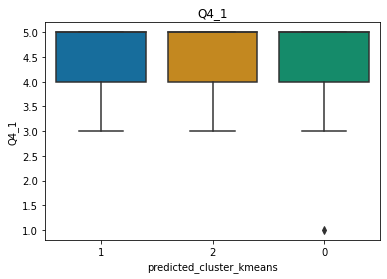

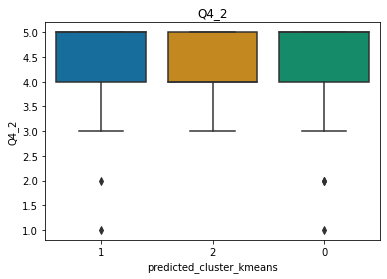

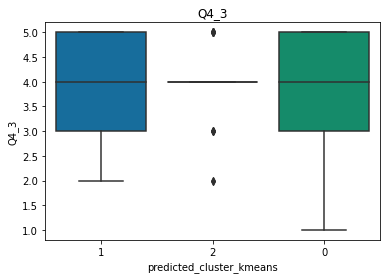

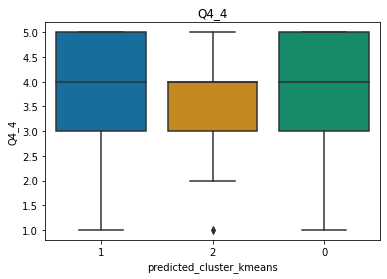

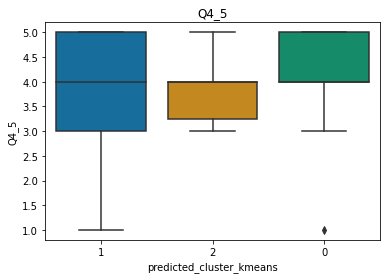

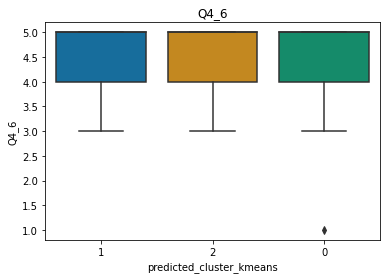

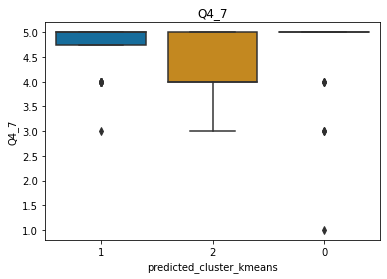

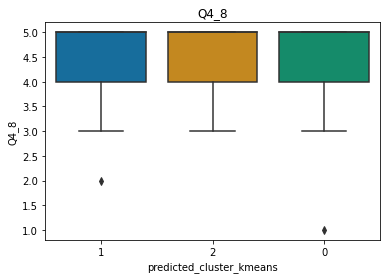

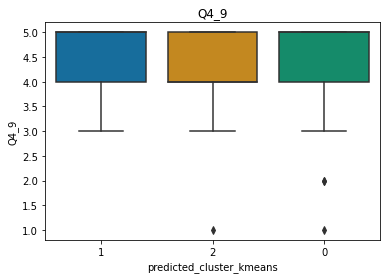

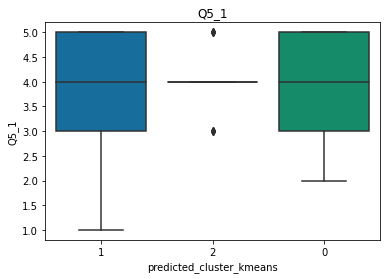

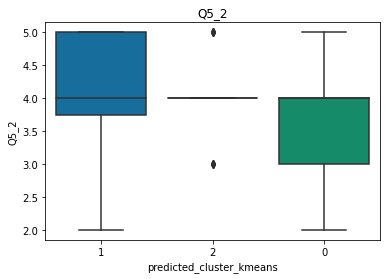

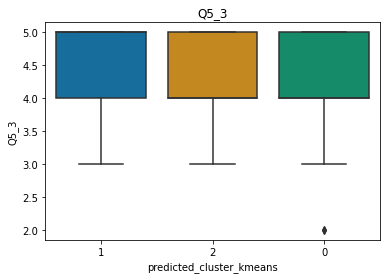

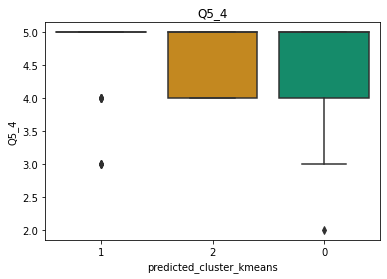

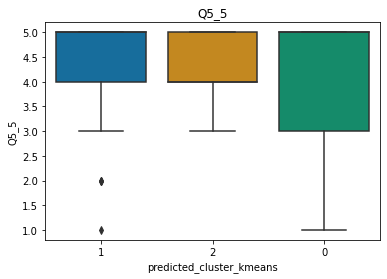

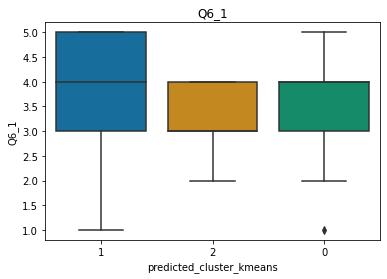

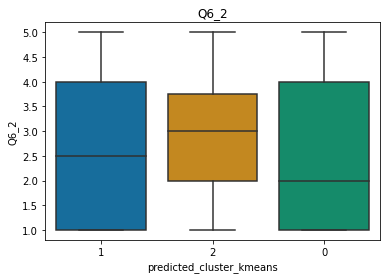

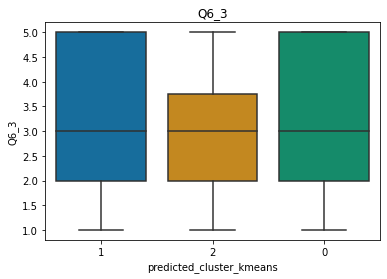

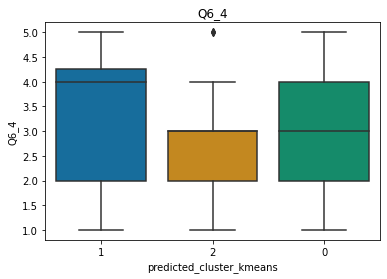

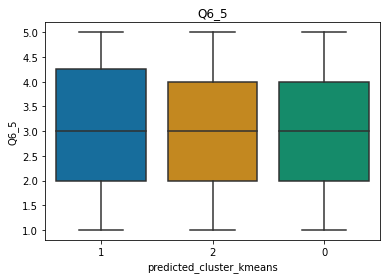

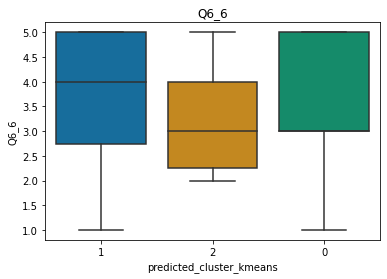

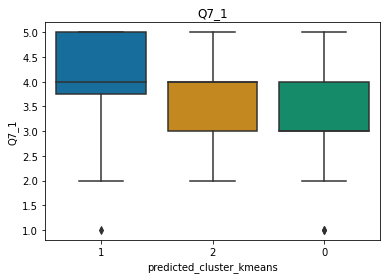

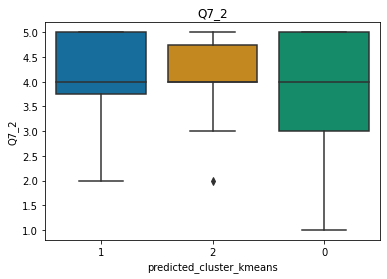

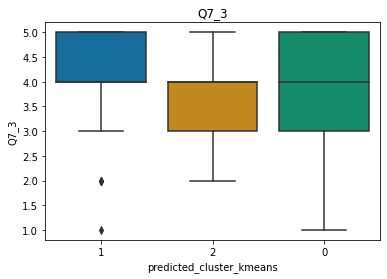

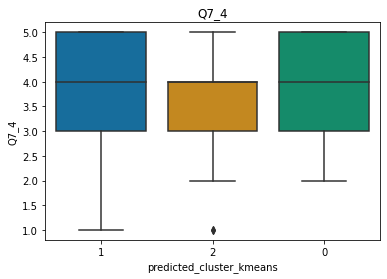

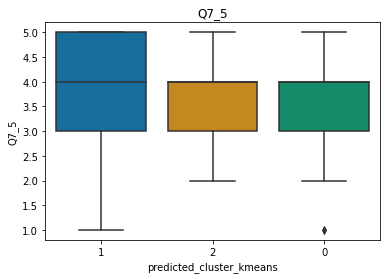

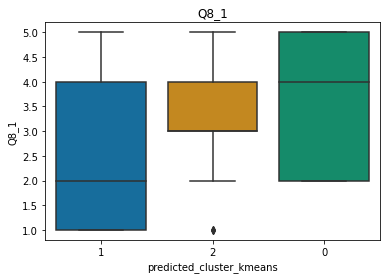

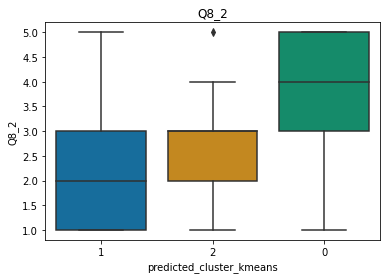

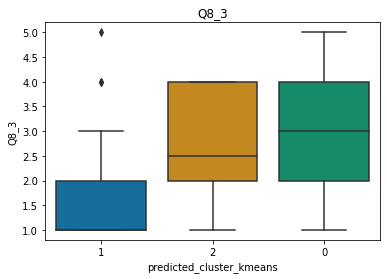

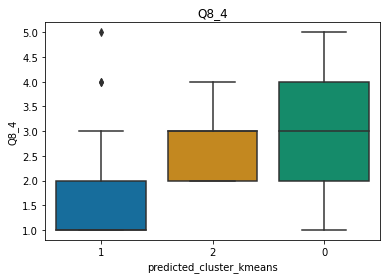

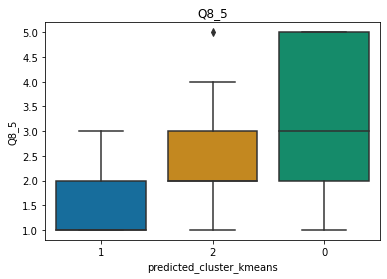

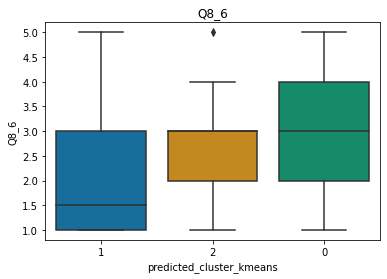

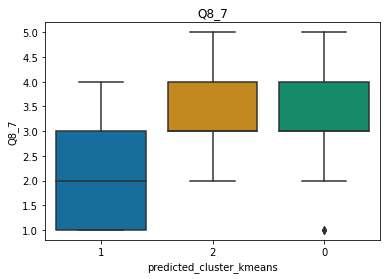

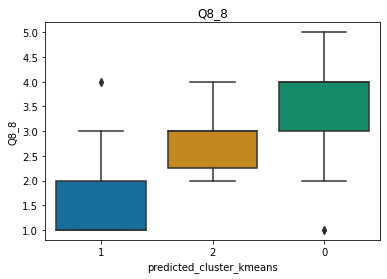

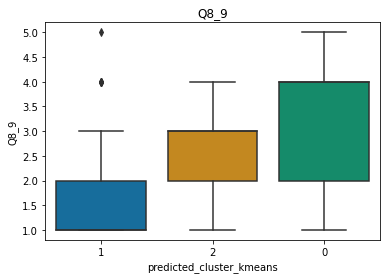

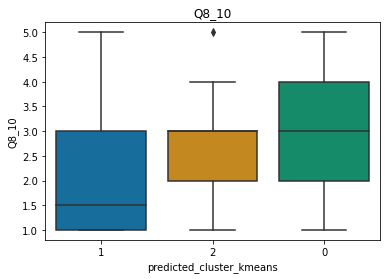

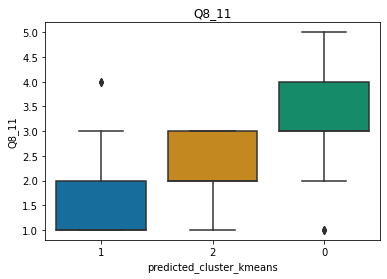

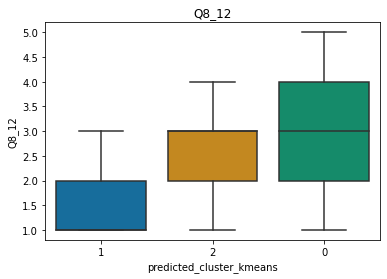

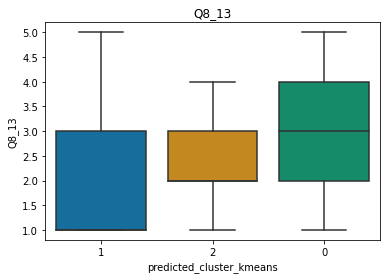

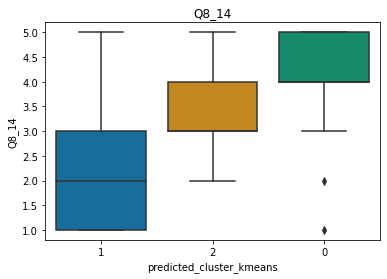

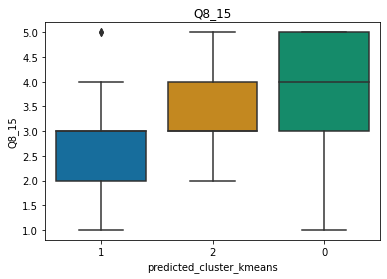

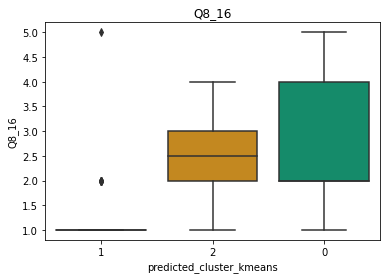

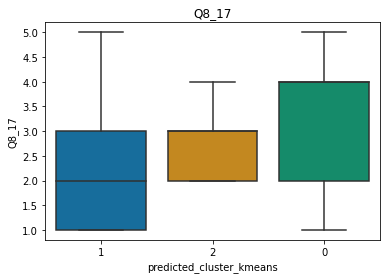

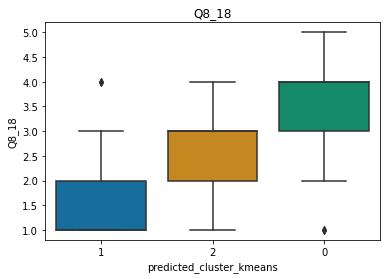

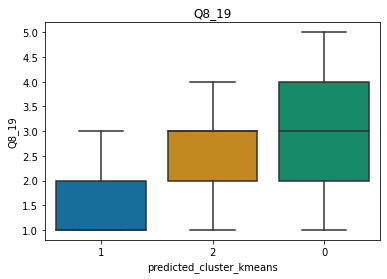

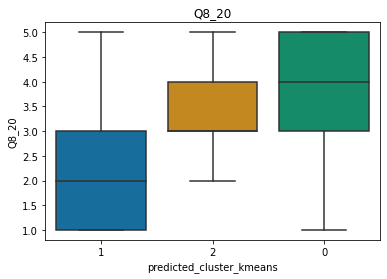

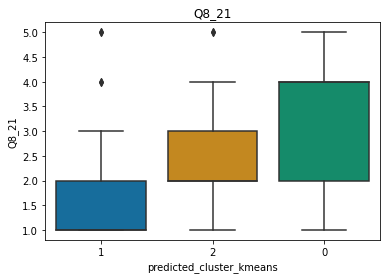

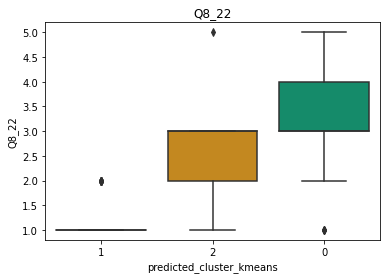

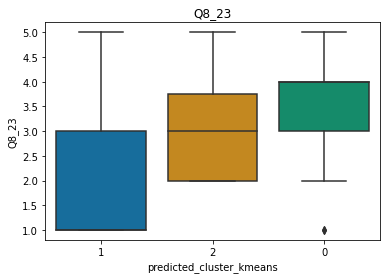

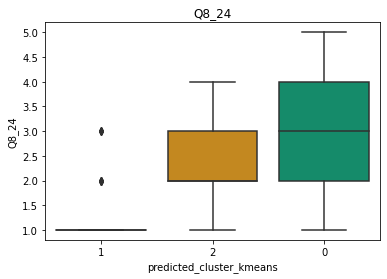

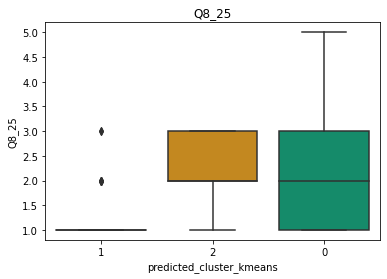

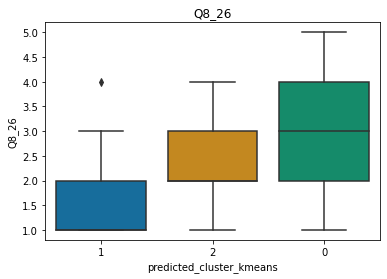

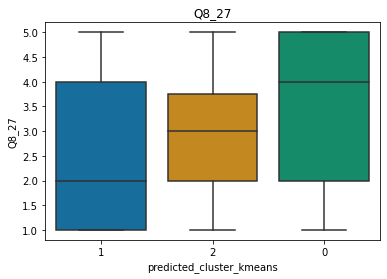

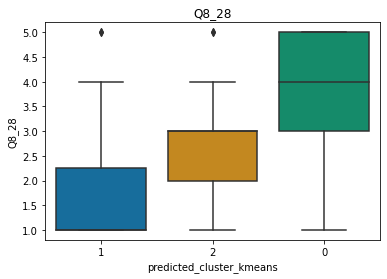

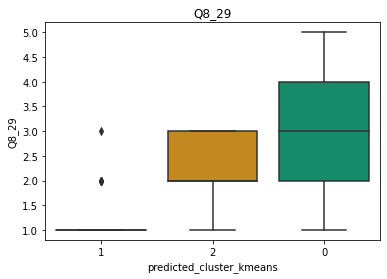

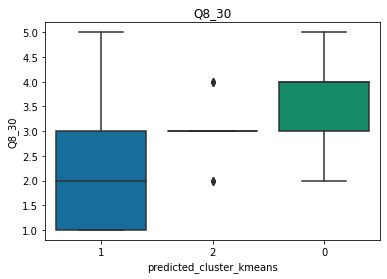

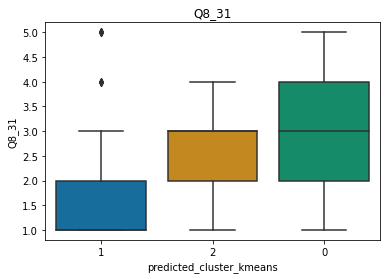

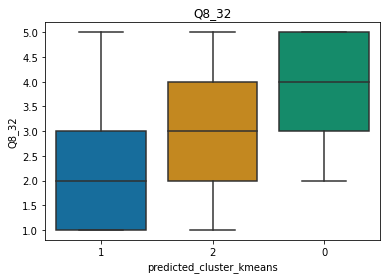

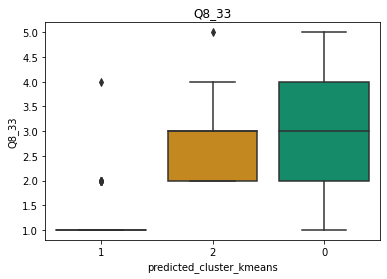

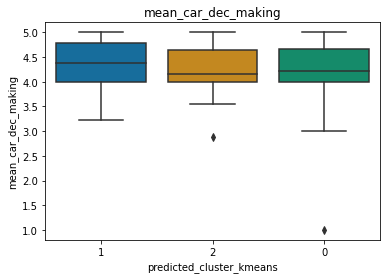

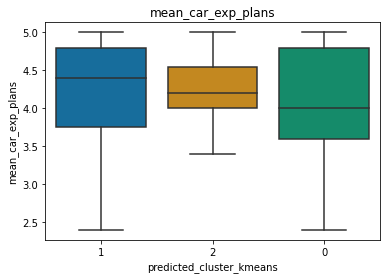

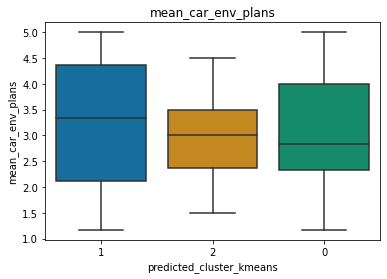

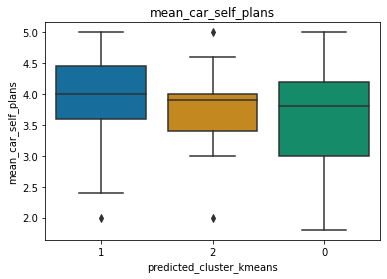

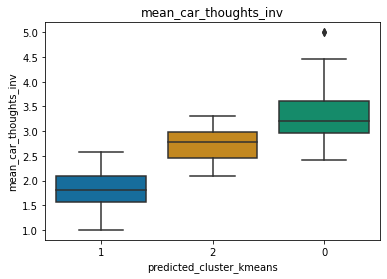

In [ ]:
import seaborn as sns
col_list=['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6',
       'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1',
       'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4',
       'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8',
       'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16',
       'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24',
       'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32',
       'Q8_33',     'mean_car_dec_making', 'mean_car_exp_plans', 'mean_car_env_plans',
       'mean_car_self_plans', 'mean_car_thoughts_inv']

for col in col_list:

    sns.boxplot(y=col, x='predicted_cluster_kmeans', 
                 data=df_for_sampling, 
                 palette="colorblind").set(title=col)
    plt.show()

In [ ]:
df_for_sampling[df_for_sampling['predicted_cluster_kmeans']=='0']['Primary Curr Major Name'].value_counts()

Computer Science             15
Biomedical Engineering        5
Electrical Engineering        5
Not Reported                  4
Engineering-Undeclared        2
Computer Science & Design     2
Mechanical Engineering        2
Engineering Physics           1
Computer Engineering          1
Name: Primary Curr Major Name, dtype: int64

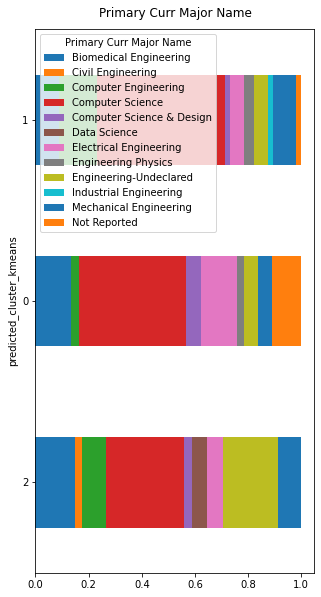

In [ ]:
stacked_bar(df_for_sampling,'predicted_cluster_kmeans',['Primary Curr Major Name'],is_perc=True)

## Hierarchical Modelling of Data

In [ ]:
df_for_sampling.columns

Index(['uin', 'Primary Curr Major Name', 'Race Description',
       'International Birth Nation Name', 'Address State Name',
       'student_status', 'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6',
       'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1',
       'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4',
       'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8',
       'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16',
       'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24',
       'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32',
       'Q8_33', 'x_projected', 'y_projected', 'predicted_cluster_hac',
       'predicted_cluster_k_proto', 'predicted_cluster_kmeans', 'Q9',
       'mean_car_dec_making', 'mean_car_exp_plans', 'mean_car_env_plans',
       'mean_car_self_plans', 'mean_car_thoughts_inv'],
      dtype='object')

(array([ 4.,  1.,  5.,  8., 12.,  7., 31., 14., 15., 30.]),
 array([2.4 , 2.66, 2.92, 3.18, 3.44, 3.7 , 3.96, 4.22, 4.48, 4.74, 5.  ]),
 <a list of 10 Patch objects>)

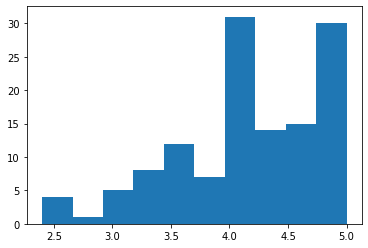

In [ ]:
plt.hist(df_for_sampling['mean_car_exp_plans'])

In [ ]:
df_combo=df_for_sampling.copy()
df_for_modelling=pd.get_dummies(df_for_modelling)

In [ ]:
print(df_for_modelling.columns.tolist())

['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33', 'x_projected', 'y_projected', 'predicted_cluster_hac', 'mean_car_dec_making', 'mean_car_exp_plans', 'mean_car_env_plans', 'mean_car_self_plans', 'mean_car_thoughts_inv', 'uin_ 6520007412', 'uin_539340448', 'uin_650245175', 'uin_650321892', 'uin_650404116', 'uin_650848633', 'uin_651422527', 'uin_651905837', 'uin_652253543', 'uin_653633469', 'uin_653708978', 'uin_653767009', 'uin_654275726', 'uin_654328323', 'uin_654795279', 'uin_654837955', 'uin_654838636', 'uin_655213388', 'uin_655453672', 'uin_655562879',

In [ ]:
final_predictor_list=['Primary Curr Major Name_Biomedical Engineering', 'Primary Curr Major Name_Civil Engineering', 'Primary Curr Major Name_Computer Engineering', 'Primary Curr Major Name_Computer Science', 'Primary Curr Major Name_Computer Science & Design', 'Primary Curr Major Name_Data Science', 'Primary Curr Major Name_Electrical Engineering', 'Primary Curr Major Name_Engineering Physics', 'Primary Curr Major Name_Engineering-Undeclared', 'Primary Curr Major Name_Industrial Engineering', 'Primary Curr Major Name_Mechanical Engineering', 'Primary Curr Major Name_Not Reported', 'Race Description_American Indian or Alaska Native', 'Race Description_Asian', 'Race Description_Black or African American', 'Race Description_Native Hawaiian or Other Pacific Islander', 'Race Description_Not Reported', 'Race Description_White', 'International Birth Nation Name_Bangladesh', 'International Birth Nation Name_Egypt', 'International Birth Nation Name_India', 'International Birth Nation Name_Indonesia', 'International Birth Nation Name_Kenya', 'International Birth Nation Name_Korea, South', 'International Birth Nation Name_Nigeria', 'International Birth Nation Name_Not Reported', 'International Birth Nation Name_Pakistan', 'International Birth Nation Name_Thailand', 'Address State Name_Illinois', 'Address State Name_Massachusetts', 'Address State Name_Not Reported', 'Address State Name_Texas', 'student_status_Domestic In State', 'student_status_Domestic Out of State', 'student_status_International',
               'predicted_cluster_kmeans_0', 'predicted_cluster_kmeans_1', 'predicted_cluster_kmeans_2' ]

final_response_list=['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33']
#df_for_modelling[['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33']]=df_for_modelling[['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33']].astype(str)

In [ ]:
col_list=['Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q4_9', 'Q5_1', 'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q8_12', 'Q8_13', 'Q8_14', 'Q8_15', 'Q8_16', 'Q8_17', 'Q8_18', 'Q8_19', 'Q8_20', 'Q8_21', 'Q8_22', 'Q8_23', 'Q8_24', 'Q8_25', 'Q8_26', 'Q8_27', 'Q8_28', 'Q8_29', 'Q8_30', 'Q8_31', 'Q8_32', 'Q8_33']
from pandas.api.types import CategoricalDtype
for col in col_list:

    cat_type = CategoricalDtype(categories=['5', '4', '3', '2', '1'], ordered=True)
    df_for_modelling[col] = df_for_modelling[col].astype(cat_type)

In [ ]:
! pip install mord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=fb1a04bf7413e519aa68095435b45cdc364d9cb2179640f8949aa84a6e927619
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [ ]:
from imblearn.over_sampling import SMOTE
import mord
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
for col in final_response_list:
      Xrc = df_for_modelling[final_predictor_list]
      yr=df_for_modelling[col]

      # scale data and encode categories
      X = pd.DataFrame(StandardScaler().fit_transform(Xrc),columns=Xrc.columns)
      le = LabelEncoder().fit(yr)
      y = yr.astype('i') 

      # split into test and train
      Xtraini,Xtest,ytraini,ytest = train_test_split(X,y,test_size = 0.30,shuffle = True,random_state = 42)

      #oversample training data due to the imbalance between categories
      #Xtrain, ytrain = SMOTE().fit_sample(Xtraini,ytraini)
      Xtrain, ytrain = Xtraini,ytraini

      model = mord.LogisticAT(alpha=.1)
      results = model.fit(Xtrain,ytrain)
      ypred = (results.predict(Xtest))

      print('Raw data:')
      print(y.value_counts())
      #print('Oversampled data:')
      #print(ytrain.value_counts())

ValueError: ignored

In [ ]:
df_combo['Q4_1'].shape

(127,)

In [ ]:
col='Q4_1'
Xrc = df_for_modelling[final_predictor_list]
yr=df_for_modelling[col]

# scale data and encode categories
X = pd.DataFrame(StandardScaler().fit_transform(Xrc),columns=Xrc.columns)
le = LabelEncoder().fit(yr)
y = yr.astype('i') 

# split into test and train
Xtraini,Xtest,ytraini,ytest = train_test_split(X,y,test_size = 0.30,shuffle = True,random_state = 42)

#oversample training data due to the imbalance between categories
#Xtrain, ytrain = SMOTE().fit_sample(Xtraini,ytraini)
Xtrain, ytrain = Xtraini,ytraini

model = mord.LogisticAT(alpha=.1)
results = model.fit(Xtrain,ytrain)
ypred = (results.predict(Xtest))

ValueError: ignored